# Name : A Machine Learning Approach for Drug Sensitivity Detection using Genome Classification

In [ ]:
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1.  LAODING THE DATASETS

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load the datasets
gdsc_dataset = pd.read_csv('/content/drive/MyDrive/CSE438_PROJECT2024/GDSC_DATASET.csv')
compounds_annotation = pd.read_csv('/content/drive/MyDrive/CSE438_PROJECT2024/Compounds-annotation.csv')
gdsc2_dataset = pd.read_csv('/content/drive/MyDrive/CSE438_PROJECT2024/GDSC2-dataset.csv')
cell_lines_details = pd.read_excel('/content/drive/MyDrive/CSE438_PROJECT2024/Cell_Lines_Details.xlsx')

from google.colab import drive
drive.mount('/content/drive')

# 2. DATA EXPLORATION

In [ ]:
# Display the first few rows of each dataset
display(gdsc_dataset.head())
display(compounds_annotation.head())
display(gdsc2_dataset.head())
display(cell_lines_details.head())

,COSMIC_ID,CELL_LINE_NAME,TCGA_DESC,DRUG_ID,DRUG_NAME,LN_IC50,AUC,Z_SCORE,GDSC Tissue descriptor 1,GDSC Tissue descriptor 2,Cancer Type (matching TCGA label),Microsatellite instability Status (MSI),Screen Medium,Growth Properties,CNA,Gene Expression,Methylation,TARGET,TARGET_PATHWAY
0,683667,PFSK-1,MB,1003,Camptothecin,-1.463887,0.930220,0.433123,nervous_system,medulloblastoma,MB,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
1,684057,ES5,UNCLASSIFIED,1003,Camptothecin,-3.360586,0.791072,-0.599569,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
2,684059,ES7,UNCLASSIFIED,1003,Camptothecin,-5.044940,0.592660,-1.516647,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
3,684062,EW-11,UNCLASSIFIED,1003,Camptothecin,-3.741991,0.734047,-0.807232,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Adherent,Y,Y,Y,TOP1,DNA replication
4,684072,SK-ES-1,UNCLASSIFIED,1003,Camptothecin,-5.142961,0.582439,-1.570016,bone,ewings_sarcoma,NaN,MSS/MSI-L,R,Semi-Adherent,Y,Y,Y,TOP1,DNA replication


,DRUG_ID,SCREENING_SITE,DRUG_NAME,SYNONYMS,TARGET,TARGET_PATHWAY
0,1,MGH,Erlotinib,"Tarceva, RG-1415, CP-358774, OSI-774, Ro-50823...",EGFR,EGFR signaling
1,3,MGH,Rapamycin,"AY-22989, Sirolimus, WY-090217, Torisel, Rapamune",MTORC1,PI3K/MTOR signaling
2,5,MGH,Sunitinib,"Sutent, Sunitinib Malate, SU-11248","PDGFR, KIT, VEGFR, FLT3, RET, CSF1R",RTK signaling
3,6,MGH,PHA-665752,"PHA665752, PHA 665752",MET,RTK signaling
4,9,MGH,MG-132,"LLL cpd, MG 132, MG132","Proteasome, CAPN1",Protein stability and degradation


,DATASET,NLME_RESULT_ID,NLME_CURVE_ID,COSMIC_ID,CELL_LINE_NAME,SANGER_MODEL_ID,TCGA_DESC,DRUG_ID,DRUG_NAME,PUTATIVE_TARGET,PATHWAY_NAME,COMPANY_ID,WEBRELEASE,MIN_CONC,MAX_CONC,LN_IC50,AUC,RMSE,Z_SCORE
0,GDSC2,343,15946310,683667,PFSK-1,SIDM01132,MB,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-1.463887,0.930220,0.089052,0.433123
1,GDSC2,343,15946548,684052,A673,SIDM00848,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-4.869455,0.614970,0.111351,-1.421100
2,GDSC2,343,15946830,684057,ES5,SIDM00263,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-3.360586,0.791072,0.142855,-0.599569
3,GDSC2,343,15947087,684059,ES7,SIDM00269,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-5.044940,0.592660,0.135539,-1.516647
4,GDSC2,343,15947369,684062,EW-11,SIDM00203,UNCLASSIFIED,1003,Camptothecin,TOP1,DNA replication,1046,Y,0.0001,0.1,-3.741991,0.734047,0.128059,-0.807232


,Sample Name,COSMIC identifier,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
0,A253,906794.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,NaN,MSS/MSI-L,D/F12,Adherent
1,BB30-HNC,753531.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
2,BB49-HNC,753532.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
3,BHY,753535.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent
4,BICR10,1290724.0,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,HNSC,MSS/MSI-L,D/F12,Adherent


# 3. DATA CLEANING and PREPARATION

In [ ]:
# Check for missing values
print(gdsc_dataset.isnull().sum())
print(compounds_annotation.isnull().sum())
print(gdsc2_dataset.isnull().sum())
print(cell_lines_details.isnull().sum())

COSMIC_ID                                      0
CELL_LINE_NAME                                 0
TCGA_DESC                                   1067
DRUG_ID                                        0
DRUG_NAME                                      0
LN_IC50                                        0
AUC                                            0
Z_SCORE                                        0
GDSC Tissue descriptor 1                    9366
GDSC Tissue descriptor 2                    9366
Cancer Type (matching TCGA label)          51446
Microsatellite instability Status (MSI)    12353
Screen Medium                               9366
Growth Properties                           9366
CNA                                         9366
Gene Expression                             9366
Methylation                                 9366
TARGET                                     27155
TARGET_PATHWAY                                 0
dtype: int64
DRUG_ID             0
SCREENING_SITE      0
DRUG_NAME   

In [ ]:
# Drop rows with missing values for simplicity
gdsc_dataset = gdsc_dataset.dropna()
compounds_annotation = compounds_annotation.dropna()
gdsc2_dataset = gdsc2_dataset.dropna()
cell_lines_details = cell_lines_details.dropna()

In [ ]:
print("Missing values in gdsc_dataset:")
print(gdsc_dataset.isna().sum())

print("\nMissing values in compounds_annotation:")
print(compounds_annotation.isna().sum())

print("\nMissing values in gdsc2_dataset:")
print(gdsc2_dataset.isna().sum())

print("\nMissing values in cell_lines_details:")
print(cell_lines_details.isna().sum())


Missing values in gdsc_dataset:
COSMIC_ID                                  0
CELL_LINE_NAME                             0
TCGA_DESC                                  0
DRUG_ID                                    0
DRUG_NAME                                  0
LN_IC50                                    0
AUC                                        0
Z_SCORE                                    0
GDSC Tissue descriptor 1                   0
GDSC Tissue descriptor 2                   0
Cancer Type (matching TCGA label)          0
Microsatellite instability Status (MSI)    0
Screen Medium                              0
Growth Properties                          0
CNA                                        0
Gene Expression                            0
Methylation                                0
TARGET                                     0
TARGET_PATHWAY                             0
dtype: int64

Missing values in compounds_annotation:
DRUG_ID           0
SCREENING_SITE    0
DRUG_NAME         0

# 4. Correlation Analysis

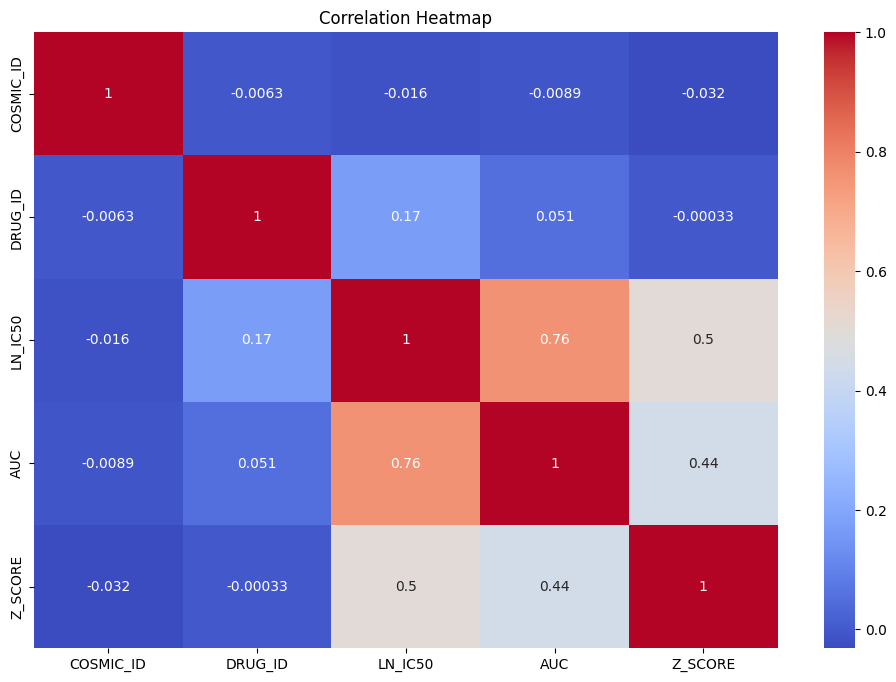

In [ ]:
# Select only numeric columns for correlation analysis
numeric_df = gdsc_dataset.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 5. Merging datasets

In [ ]:
# Merge GDSC2 dataset with Cell Lines Details on COSMIC_ID
merged_df = pd.merge(gdsc2_dataset, cell_lines_details, left_on='COSMIC_ID', right_on='COSMIC identifier', how='left')

# Merge the resulting dataframe with Compounds Annotation on DRUG_ID
final_df = pd.merge(merged_df, compounds_annotation, on='DRUG_ID', how='left')

print(final_df.head())

#  the median of the LN_IC50 column
median_LN_IC50 = final_df['LN_IC50'].median()
print(f'Median of LN_IC50: {median_LN_IC50}')

# Add the median of LN_IC50 as a new column to final_df
final_df['Median_LN_IC50'] = median_LN_IC50
print(final_df.head())



  DATASET  NLME_RESULT_ID  NLME_CURVE_ID  COSMIC_ID CELL_LINE_NAME  \
0   GDSC2             343       15946310     683667         PFSK-1   
1   GDSC2             343       15946548     684052           A673   
2   GDSC2             343       15946830     684057            ES5   
3   GDSC2             343       15947087     684059            ES7   
4   GDSC2             343       15947369     684062          EW-11   

  SANGER_MODEL_ID     TCGA_DESC  DRUG_ID   DRUG_NAME_x PUTATIVE_TARGET  ...  \
0       SIDM01132            MB     1003  Camptothecin            TOP1  ...   
1       SIDM00848  UNCLASSIFIED     1003  Camptothecin            TOP1  ...   
2       SIDM00263  UNCLASSIFIED     1003  Camptothecin            TOP1  ...   
3       SIDM00269  UNCLASSIFIED     1003  Camptothecin            TOP1  ...   
4       SIDM00203  UNCLASSIFIED     1003  Camptothecin            TOP1  ...   

  GDSC\nTissue\ndescriptor 2  Cancer Type\n(matching TCGA label)  \
0            medulloblastoma        

# **6. USING RANDOM FOREST, CATBOOST CLASSIFIER CLASSIFIER , NAIVE BAYES ,GRADIENT BOOSTING CLASSIFIER AND KNN OF MACHINE LEARNING; NEURAL NETWORK  OF DEEP LEARNING to know high or low drug sensitivity dependding on LN_IC50**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


# Implementing Mchine learning algorithms :  RF, CATBOOST, NAIVE BAYES, GRADIENT BOOST classifier.

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Remove duplicate column names if present
final_df = final_df.loc[:, ~final_df.columns.duplicated()]

# Calculate the median of the LN_IC50 column
median_LN_IC50 = final_df['LN_IC50'].median()

# Convert LN_IC50 to categorical (high = 1, low = 0) based on the median
final_df['Drug_Response'] = np.where(final_df['LN_IC50'] > median_LN_IC50, 1, 0)

# Define features and the new target variable
# Removed the duplicate 'DRUG_ID'
X = final_df[['DRUG_ID', 'AUC', 'Z_SCORE',
                 'Whole Exome Sequencing (WES)',
    'Copy Number Alterations (CNA)',
    'Gene Expression',
    'Methylation',
    'GDSC\nTissue descriptor 1',
    'GDSC\nTissue\ndescriptor 2',
    'Cancer Type\n(matching TCGA label)',
    'Microsatellite \ninstability Status (MSI)',
    'Growth Properties']]

# The new target variable becomes Drug_Response (binary: high or low)
y = final_df['Drug_Response']

# Hot-one encoding for categorical variables
X = pd.get_dummies(X, columns=[
    'Whole Exome Sequencing (WES)',
    'Copy Number Alterations (CNA)',
    'Gene Expression',
    'Methylation',
    'DRUG_ID',
    'GDSC\nTissue descriptor 1',
    'GDSC\nTissue\ndescriptor 2',
    'Cancer Type\n(matching TCGA label)',
    'Microsatellite \ninstability Status (MSI)',
    'Growth Properties',
])

# Remove any duplicate columns resulting from one-hot encoding
X = X.loc[:, ~X.columns.duplicated()]
X = X.astype(float)
y = np.asarray(y, dtype=int)

# Split the data into training and testing sets (for classification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions with Random Forest Classifier
rf_y_pred_class = rf_model.predict(X_test)

# Initialize and train CatBoost Classifier
catboost_model = CatBoostClassifier(learning_rate=0.1, depth=6, iterations=1000, random_state=42, silent=True)
catboost_model.fit(X_train, y_train)

# Make predictions with CatBoost Classifier
catboost_y_pred_class = catboost_model.predict(X_test)

# Initialize and train Naive Bayes Classifier
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Make predictions with Naive Bayes Classifier
nb_y_pred_class = nb_model.predict(X_test)

# Initialize and train Gradient Boosting Classifier
gbm_model = GradientBoostingClassifier(random_state=42)
gbm_model.fit(X_train, y_train)

# Make predictions with Gradient Boosting Classifier
gbm_y_pred_class = gbm_model.predict(X_test)


# Evaluate Random Forest Classifier
rf_precision = precision_score(y_test, rf_y_pred_class)
rf_recall = recall_score(y_test, rf_y_pred_class)
rf_f1 = f1_score(y_test, rf_y_pred_class)
rf_accuracy = accuracy_score(y_test, rf_y_pred_class)

# Evaluate CatBoost Classifier
catboost_precision = precision_score(y_test, catboost_y_pred_class)
catboost_recall = recall_score(y_test, catboost_y_pred_class)
catboost_f1 = f1_score(y_test, catboost_y_pred_class)
catboost_accuracy = accuracy_score(y_test, catboost_y_pred_class)

# Evaluate Naive Bayes Classifier
nb_precision = precision_score(y_test, nb_y_pred_class)
nb_recall = recall_score(y_test, nb_y_pred_class)
nb_f1 = f1_score(y_test, nb_y_pred_class)
nb_accuracy = accuracy_score(y_test, nb_y_pred_class)

# Evaluate Gradient Boosting Classifier
gbm_precision = precision_score(y_test, gbm_y_pred_class)
gbm_recall = recall_score(y_test, gbm_y_pred_class)
gbm_f1 = f1_score(y_test, gbm_y_pred_class)
gbm_accuracy = accuracy_score(y_test, gbm_y_pred_class)

# Create a DataFrame to display metrics for all models
metrics_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score', 'Accuracy'],
    'Random Forest': [rf_precision, rf_recall, rf_f1, rf_accuracy],
    'CatBoost': [catboost_precision, catboost_recall, catboost_f1, catboost_accuracy],
    'Naive Bayes': [nb_precision, nb_recall, nb_f1, nb_accuracy],
    'Gradient Boosting': [gbm_precision, gbm_recall, gbm_f1, gbm_accuracy]
})
print(metrics_df)


      Metric  Random Forest  CatBoost  Naive Bayes  Gradient Boosting
0  Precision       0.977539  0.998037     0.792752           0.878882
1     Recall       0.972512  0.998224     0.859053           0.942032
2   F1 Score       0.975019  0.998130     0.824572           0.909362
3   Accuracy       0.975073  0.998129     0.817164           0.906068


checking train accuracy, validation accuracy, train logloss and validation logloss of CatBoost .

0:	learn: 0.8489200	test: 0.8496142	best: 0.8496142 (0)	total: 35.9ms	remaining: 35.9s
100:	learn: 0.9336855	test: 0.9330937	best: 0.9330937 (100)	total: 3.37s	remaining: 30s
200:	learn: 0.9622428	test: 0.9606863	best: 0.9606863 (200)	total: 8.48s	remaining: 33.7s
300:	learn: 0.9809277	test: 0.9791301	best: 0.9791301 (300)	total: 13.1s	remaining: 30.4s
400:	learn: 0.9913700	test: 0.9888051	best: 0.9888343 (399)	total: 16.4s	remaining: 24.5s
500:	learn: 0.9959736	test: 0.9944172	best: 0.9944172 (499)	total: 19.7s	remaining: 19.7s
600:	learn: 0.9974863	test: 0.9962586	best: 0.9962879 (594)	total: 25.7s	remaining: 17.1s
700:	learn: 0.9984362	test: 0.9966386	best: 0.9966678 (690)	total: 29.1s	remaining: 12.4s
800:	learn: 0.9989624	test: 0.9972524	best: 0.9972524 (783)	total: 32.4s	remaining: 8.06s
900:	learn: 0.9992766	test: 0.9975740	best: 0.9976032 (895)	total: 37.3s	remaining: 4.1s
999:	learn: 0.9994373	test: 0.9978370	best: 0.9978370 (982)	total: 42.1s	remaining: 0us

bestTest = 0.9978

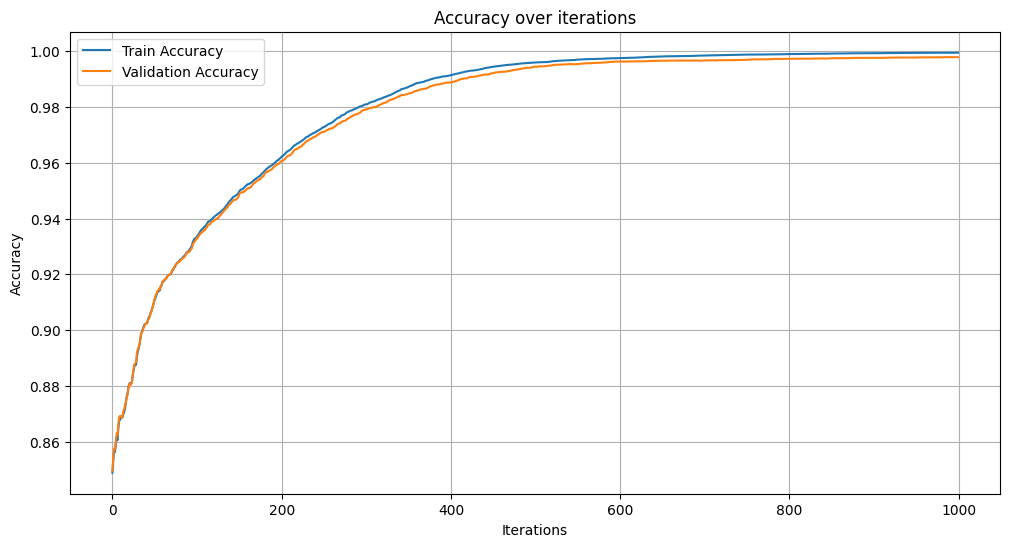

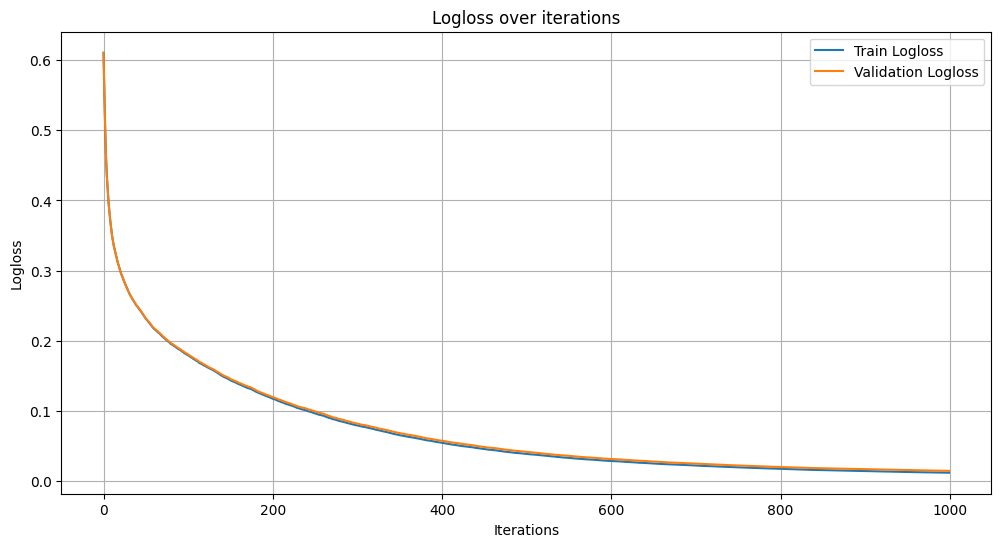

In [ ]:
import matplotlib.pyplot as plt
from catboost import Pool

# Define a validation set (for monitoring validation loss/accuracy)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Pool object required for evaluation
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)

# Initialize and train CatBoost Classifier
catboost_model = CatBoostClassifier(
    learning_rate=0.1,
    depth=6,
    iterations=1000,
    eval_metric='Accuracy',  # Use accuracy as a metric
    random_state=42,
    silent=True
)

# Train the model with logging and validation set
catboost_model.fit(
    train_pool,
    eval_set=val_pool,
    plot=False,
    verbose=100  # Shows output every 100 iterations
)

# Get evaluation results over iterations
eval_results = catboost_model.get_evals_result()

# Extract training and validation accuracy
train_accuracy = eval_results['learn']['Accuracy']
val_accuracy = eval_results['validation']['Accuracy']

# Extract training and validation loss (logloss by default)
train_loss = eval_results['learn']['Logloss']
val_loss = eval_results['validation']['Logloss']

# Plot Accuracy over iterations
plt.figure(figsize=(12, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy over iterations')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Loss (Logloss) over iterations
plt.figure(figsize=(12, 6))
plt.plot(train_loss, label='Train Logloss')
plt.plot(val_loss, label='Validation Logloss')
plt.title('Logloss over iterations')
plt.xlabel('Iterations')
plt.ylabel('Logloss')
plt.legend()
plt.grid()
plt.show()


# Visualization of the selected features

 1. HEXBIN PLOT OF LN_IC50, AUC, Z-SCORE.

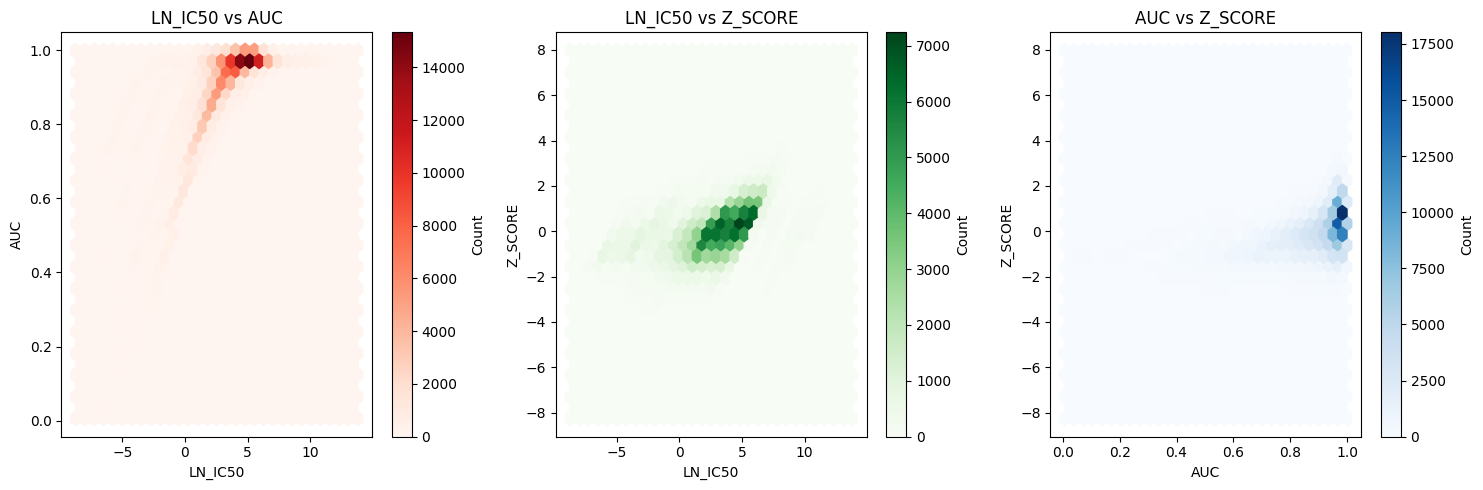

In [ ]:
plt.figure(figsize=(15, 5))

# LN_IC50 vs AUC with red hexbin
plt.subplot(1, 3, 1)
plt.hexbin(final_df['LN_IC50'], final_df['AUC'], gridsize=30, cmap='Reds')
plt.title('LN_IC50 vs AUC')
plt.xlabel('LN_IC50')
plt.ylabel('AUC')
plt.colorbar(label='Count')

# LN_IC50 vs Z_SCORE with green hexbin
plt.subplot(1, 3, 2)
plt.hexbin(final_df['LN_IC50'], final_df['Z_SCORE'], gridsize=30, cmap='Greens')
plt.title('LN_IC50 vs Z_SCORE')
plt.xlabel('LN_IC50')
plt.ylabel('Z_SCORE')
plt.colorbar(label='Count')

# AUC vs Z_SCORE with blue hexbin
plt.subplot(1, 3, 3)
plt.hexbin(final_df['AUC'], final_df['Z_SCORE'], gridsize=30, cmap='Blues')
plt.title('AUC vs Z_SCORE')
plt.xlabel('AUC')
plt.ylabel('Z_SCORE')
plt.colorbar(label='Count')

plt.tight_layout()
plt.show()


          2. Histograms for LN_IC50, AUC, and Z_SCORE

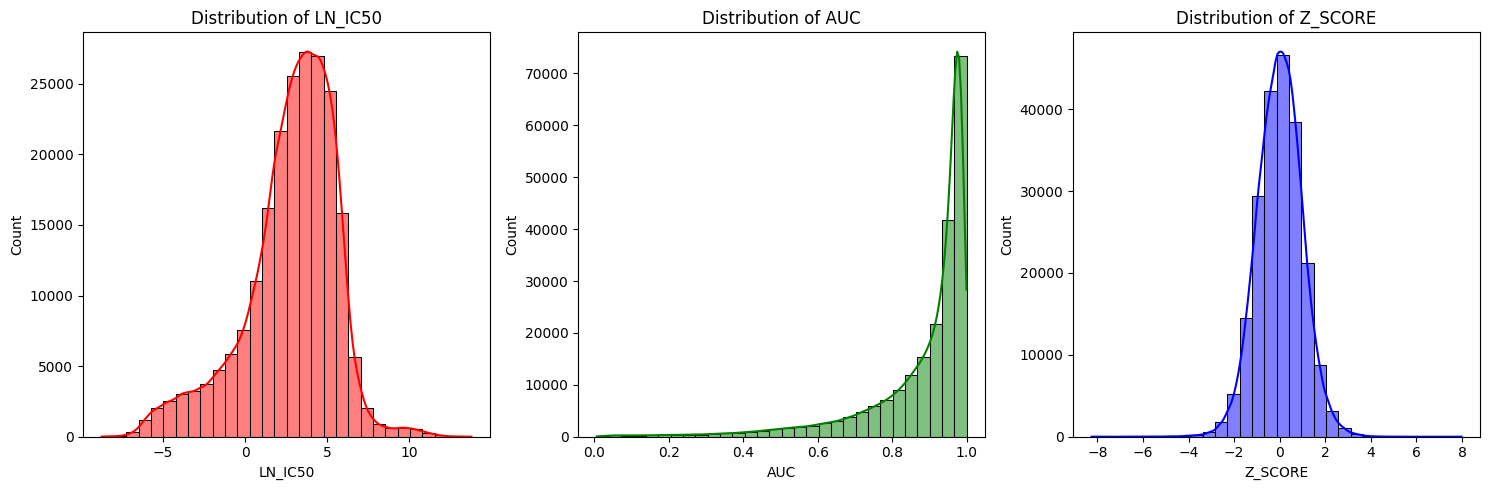

In [ ]:
# Histograms for LN_IC50, AUC, and Z_SCORE
plt.figure(figsize=(15, 5))

# Histogram for LN_IC50
plt.subplot(1, 3, 1)
sns.histplot(final_df['LN_IC50'], bins=30, kde=True, color='red')
plt.title('Distribution of LN_IC50')

# Histogram for AUC
plt.subplot(1, 3, 2)
sns.histplot(final_df['AUC'], bins=30, kde=True, color='green')
plt.title('Distribution of AUC')

# Histogram for Z_SCORE
plt.subplot(1, 3, 3)
sns.histplot(final_df['Z_SCORE'], bins=30, kde=True, color='blue')
plt.title('Distribution of Z_SCORE')

plt.tight_layout()
plt.show()


                     3. Drug Sensitivity based on LN_IC50

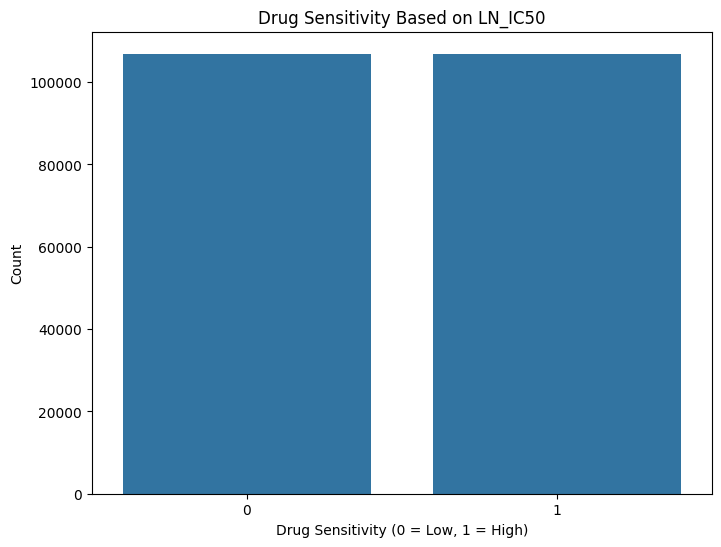

In [ ]:
# Visualize Drug Sensitivity based on LN_IC50
plt.figure(figsize=(8, 6))
sns.countplot(x='Drug_Response', data=final_df)
plt.title('Drug Sensitivity Based on LN_IC50')
plt.xlabel('Drug Sensitivity (0 = Low, 1 = High)')
plt.ylabel('Count')
plt.show()


The image shows a bar chart depicting the distribution of drug sensitivity based on the LN_IC50 values. The drug sensitivity has been classified into two categories:

0 (Low Sensitivity): Represented on the left side of the x-axis.
1 (High Sensitivity): Represented on the right side of the x-axis.
Key Observations:
The y-axis indicates the Count of samples.
Both classes (0 and 1) have nearly equal counts, around 100,000 samples each, implying a balanced dataset for drug sensitivity classification based on LN_IC50.

                     4. Top 20 tissue types in GDSC dataset

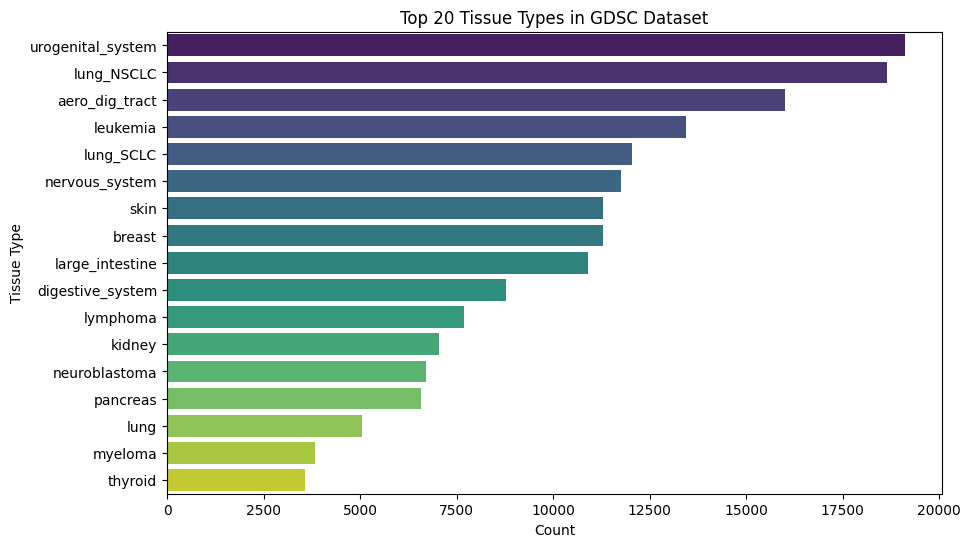

In [ ]:
# Top 20 tissue types in GDSC dataset
tissue_types = final_df['GDSC\nTissue descriptor 1'].value_counts().head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=tissue_types.values, y=tissue_types.index, palette='viridis')
plt.title('Top 20 Tissue Types in GDSC Dataset')
plt.xlabel('Count')
plt.ylabel('Tissue Type')
plt.show()


The image shows a horizontal bar chart displaying the Top 20 Tissue Types in the GDSC (Genomics of Drug Sensitivity in Cancer) Dataset. Each bar represents the count of samples for a particular tissue type in the dataset.
Key Observations:
x-axis: Represents the Count of samples for each tissue type.
y-axis: Lists the top 20 tissue types.
Tissue Type Distribution:
Urogenital_system has the highest sample count, approaching 20,000.
Lung_Non-Small Cell Lung Cancer (NSCLC) follows closely with a count slightly below 20,000.
Other notable tissue types include aero_dig_tract, leukemia, lung_SCLC, and nervous_system, each with counts ranging between 7,500 to 17,500.
Thyroid has the fewest samples, with fewer than 3,000.
The color gradient used in the chart helps differentiate between the tissue types, with darker shades representing higher counts and lighter shades representing lower counts. This visualization provides an overview of tissue type representation in the GDSC dataset, which can be useful for analysis in drug sensitivity studies.

               5. LN_IC50 for each Cancer Type (matching TCGA label)

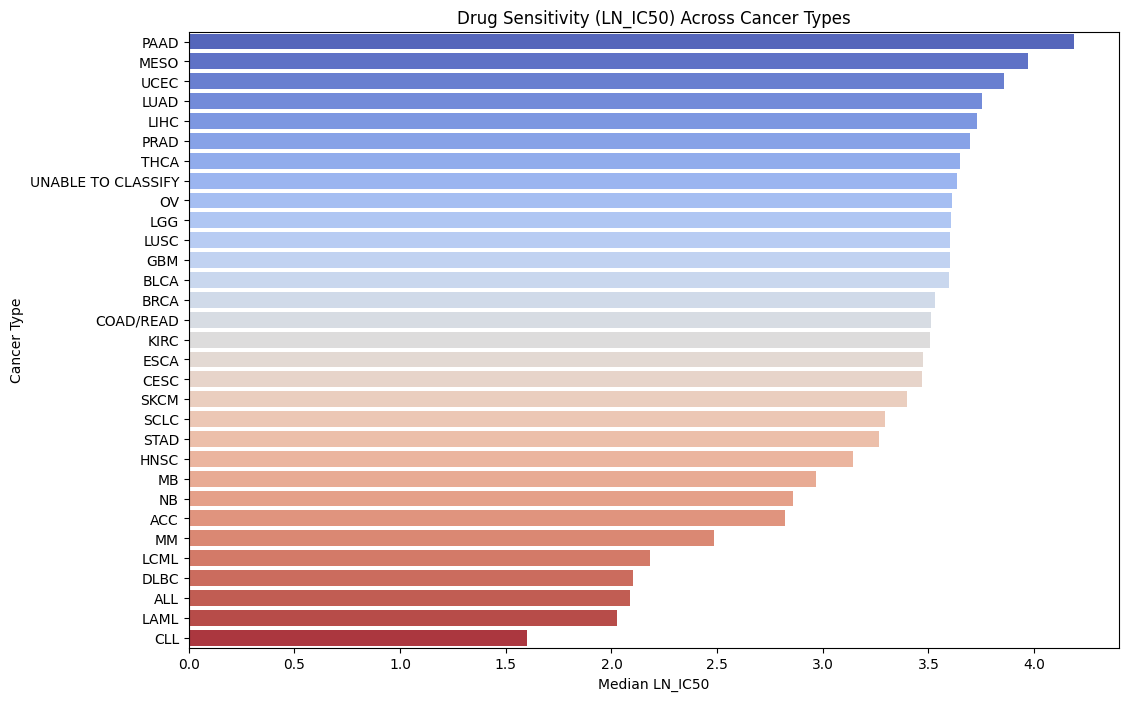

In [ ]:
# Median LN_IC50 for each Cancer Type
cancer_types = final_df.groupby('Cancer Type\n(matching TCGA label)')['LN_IC50'].median().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=cancer_types.values, y=cancer_types.index, palette='coolwarm')
plt.title('Drug Sensitivity (LN_IC50) Across Cancer Types')
plt.xlabel('Median LN_IC50')
plt.ylabel('Cancer Type')
plt.show()


              6.  stacked bar chart for Cancer Type\n matching TCGA label and Growth Properties

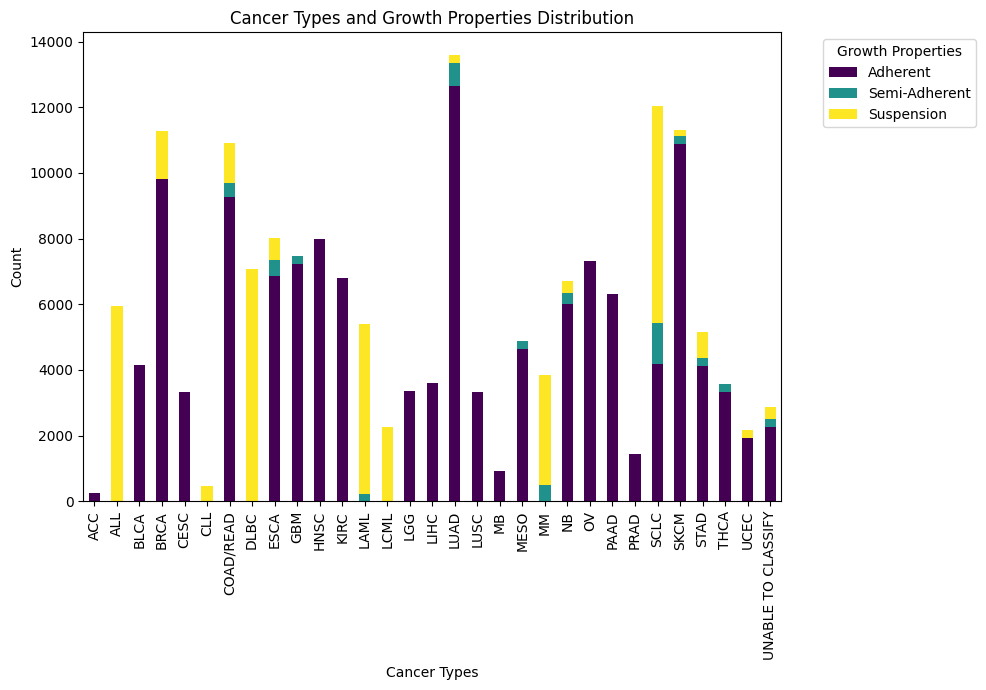

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a pivot table for stacked bar chart
df_pivot = df_grouped.pivot_table(index='Cancer Type\n(matching TCGA label)',
                                  columns='Growth Properties', values='count', fill_value=0)

# Plot a stacked bar chart
df_pivot.plot(kind='bar', stacked=True, figsize=(10, 7), colormap='viridis')

plt.title('Cancer Types and Growth Properties Distribution')
plt.xlabel('Cancer Types')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Growth Properties', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


              7. Drug efficacy across Tissue types

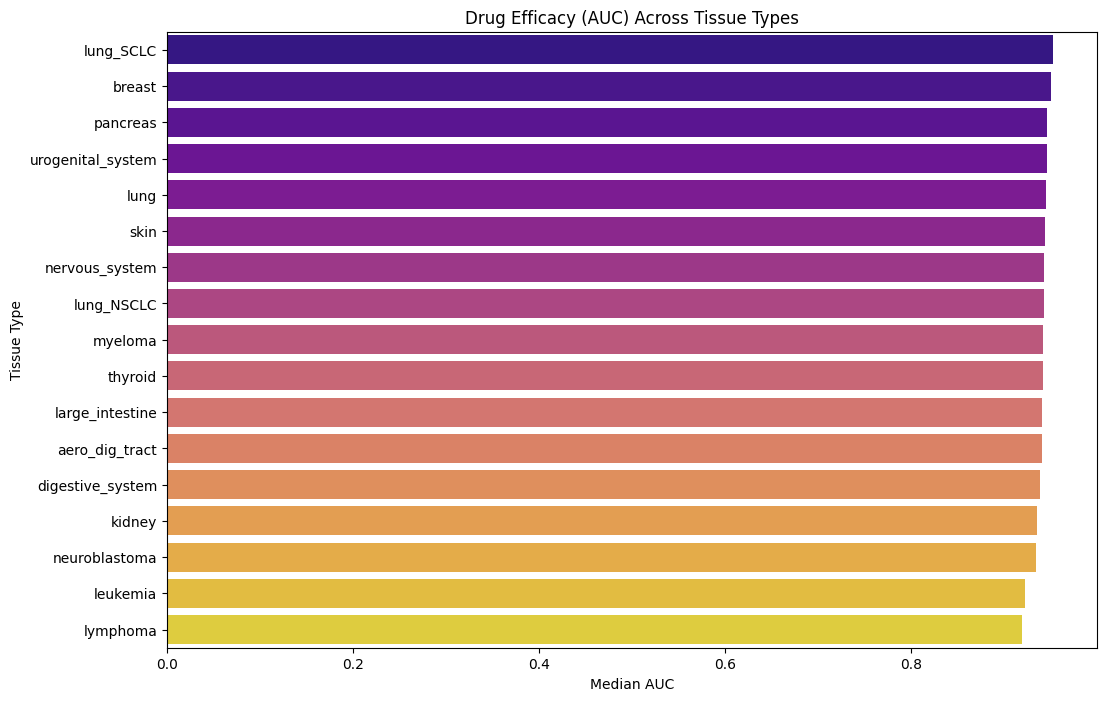

In [ ]:
# Median AUC for each Tissue Type
tissue_types_auc = final_df.groupby('GDSC\nTissue descriptor 1')['AUC'].median().sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x=tissue_types_auc.values, y=tissue_types_auc.index, palette='plasma')
plt.title('Drug Efficacy (AUC) Across Tissue Types')
plt.xlabel('Median AUC')
plt.ylabel('Tissue Type')
plt.show()


               8. the impact of MSI on drug response (LN_IC50)

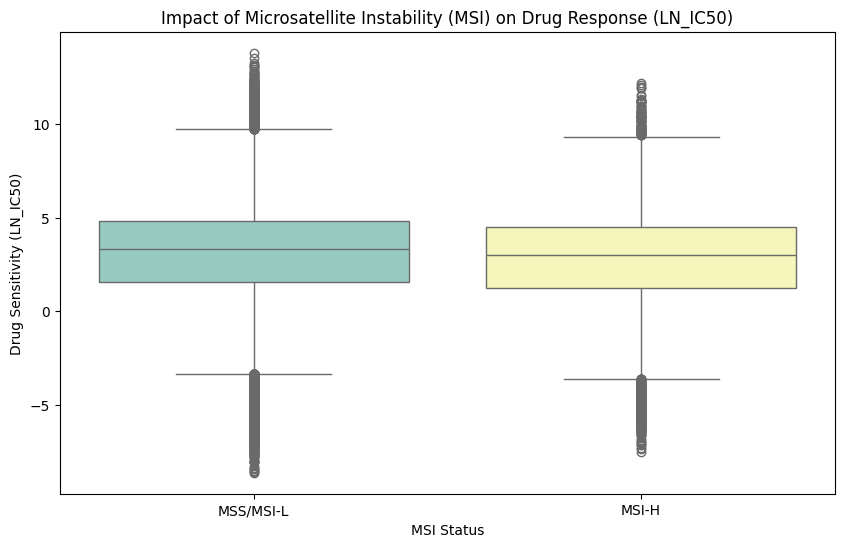

In [ ]:
# Boxplot to visualize the impact of MSI on drug response (LN_IC50)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Microsatellite \ninstability Status (MSI)', y='LN_IC50', data=final_df, palette='Set3')
plt.title('Impact of Microsatellite Instability (MSI) on Drug Response (LN_IC50)')
plt.xlabel('MSI Status')
plt.ylabel('Drug Sensitivity (LN_IC50)')
plt.show()


# Predictive Modeling Using Deep Learning Model

Implementing NEURAL NETWORK

Epoch [10/100], Train Loss: 0.0229, Train Accuracy: 0.9903, Val Loss: 0.0294, Val Accuracy: 0.9876
Epoch [20/100], Train Loss: 0.0141, Train Accuracy: 0.9943, Val Loss: 0.0271, Val Accuracy: 0.9887
Epoch [30/100], Train Loss: 0.0111, Train Accuracy: 0.9954, Val Loss: 0.0300, Val Accuracy: 0.9895
Epoch [40/100], Train Loss: 0.0091, Train Accuracy: 0.9962, Val Loss: 0.0294, Val Accuracy: 0.9900
Epoch [50/100], Train Loss: 0.0076, Train Accuracy: 0.9969, Val Loss: 0.0304, Val Accuracy: 0.9901
Epoch [60/100], Train Loss: 0.0067, Train Accuracy: 0.9972, Val Loss: 0.0297, Val Accuracy: 0.9915
Epoch [70/100], Train Loss: 0.0059, Train Accuracy: 0.9977, Val Loss: 0.0398, Val Accuracy: 0.9896
Epoch [80/100], Train Loss: 0.0056, Train Accuracy: 0.9976, Val Loss: 0.0351, Val Accuracy: 0.9919
Epoch [90/100], Train Loss: 0.0051, Train Accuracy: 0.9977, Val Loss: 0.0548, Val Accuracy: 0.9899
Epoch [100/100], Train Loss: 0.0051, Train Accuracy: 0.9979, Val Loss: 0.0308, Val Accuracy: 0.9912
Accuracy 

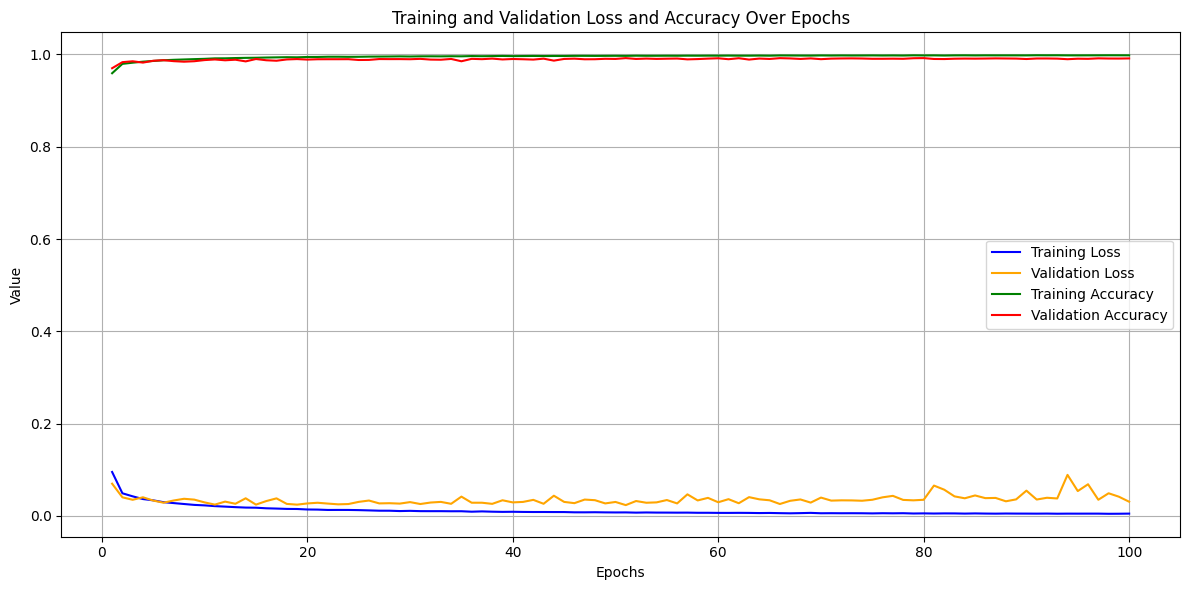

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Convert the data to PyTorch tensors
X_tensor = torch.FloatTensor(X_train.values).to(device)
y_tensor = torch.FloatTensor(y_train).to(device)
X_val_tensor = torch.FloatTensor(X_test.values).to(device)
y_val_tensor = torch.FloatTensor(y_test).to(device)

# Create a TensorDataset and DataLoader
train_dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Define the neural network model
class DrugResponseNN(nn.Module):
    def __init__(self, input_size):
        super(DrugResponseNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
        self.fc2 = nn.Linear(128, 64)           # Second hidden layer
        self.fc3 = nn.Linear(64, 1)             # Output layer
        self.relu = nn.ReLU()                    # Activation function
        self.sigmoid = nn.Sigmoid()              # Sigmoid for binary classification

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

# Initialize the model, loss function, and optimizer
input_size = X_tensor.shape[1]  # Number of features
model = DrugResponseNN(input_size).to(device)
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    correct_predictions = 0
    total_predictions = 0

    # Training Phase
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()  # Forward pass
        loss = criterion(outputs, batch_y)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        # Calculate metrics
        epoch_loss += loss.item()  # Aggregate loss
        predicted_labels = (outputs >= 0.5).float()  # Convert probabilities to binary
        correct_predictions += (predicted_labels == batch_y).sum().item()  # Count correct predictions
        total_predictions += batch_y.size(0)  # Total predictions made

    # Calculate average loss and accuracy for the epoch
    average_loss = epoch_loss / len(train_loader)
    accuracy = correct_predictions / total_predictions
    train_losses.append(average_loss)
    train_accuracies.append(accuracy)

    # Validation Phase
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor).squeeze()
        val_loss = criterion(val_outputs, y_val_tensor)  # Validation loss
        val_losses.append(val_loss.item())

        val_predicted_labels = (val_outputs >= 0.5).float()  # Convert probabilities to binary
        val_accuracy = (val_predicted_labels == y_val_tensor).float().mean().item()  # Validation accuracy
        val_accuracies.append(val_accuracy)

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {average_loss:.4f}, Train Accuracy: {accuracy:.4f}, Val Loss: {val_loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}')

# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_val_tensor).squeeze()
    test_predictions = (test_outputs >= 0.5).float()  # Convert probabilities to binary

# Calculate test accuracy
test_accuracy = (test_predictions == y_val_tensor).float().mean()
print(f'Accuracy of the Neural Network on Test Set: {test_accuracy:.4f}')

# Plot the training and validation loss and accuracy
epochs_range = np.arange(1, num_epochs + 1)
plt.figure(figsize=(12, 6))

# Plotting the loss
plt.subplot(1, 1, 1)
plt.plot(epochs_range, train_losses, label='Training Loss', color='blue')
plt.plot(epochs_range, val_losses, label='Validation Loss', color='orange')
plt.plot(epochs_range, train_accuracies, label='Training Accuracy', color='green')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy', color='red')

plt.title('Training and Validation Loss and Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Ensure the tensors are on the CPU for conversion to NumPy
test_predictions_np = test_predictions.cpu().numpy()  # Predicted labels (from previous cell)
y_val_tensor_np = y_val_tensor.cpu().numpy()          # True labels

# Calculate precision, recall, and F1 score
precision = precision_score(y_val_tensor_np, test_predictions_np)
recall = recall_score(y_val_tensor_np, test_predictions_np)
f1 = f1_score(y_val_tensor_np, test_predictions_np)

# Print the metrics
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')


Precision: 0.9898
Recall: 0.9917
F1 Score: 0.9908


Implementing KNN

Validation Accuracy of KNN: 0.9415
Validation Log Loss of KNN: 0.4247


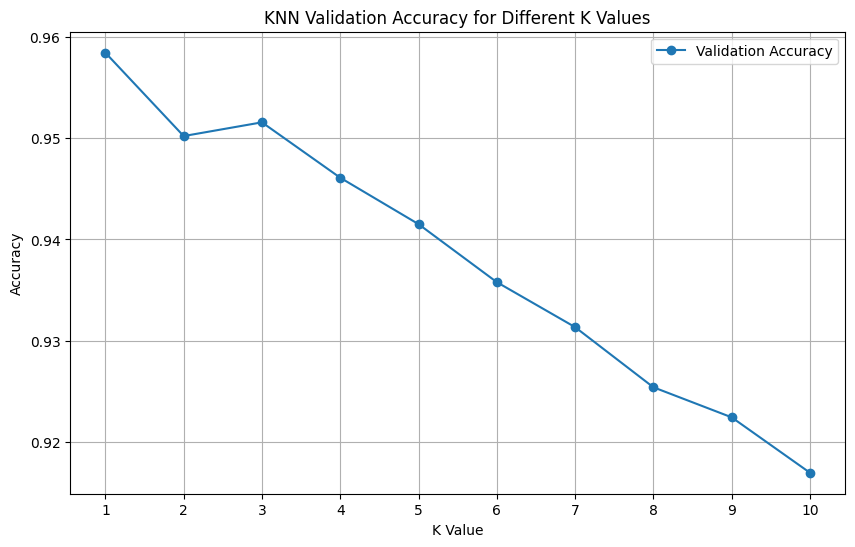

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import StandardScaler

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)  # Fit and transform the training data
X_val = scaler.transform(X_val)          # Only transform the validation data

# Initialize KNN classifier
k = 5
knn = KNeighborsClassifier(n_neighbors=k)

# Train the model
knn.fit(X_train, y_train)

# Validate the model
val_predictions = knn.predict(X_val)
val_proba = knn.predict_proba(X_val)[:, 1]  # Get probabilities for the positive class

# Calculate accuracy and log loss for validation set
val_accuracy = accuracy_score(y_val, val_predictions)
val_log_loss = log_loss(y_val, val_proba)

print(f'Validation Accuracy of KNN: {val_accuracy:.4f}')
print(f'Validation Log Loss of KNN: {val_log_loss:.4f}')

# (Optional) You can create plots to visualize performance
# Create a plot for accuracy
k_values = range(1, 11)
accuracies = [accuracy_score(y_val, KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train).predict(X_val)) for k in k_values]

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', label='Validation Accuracy')
plt.title('KNN Validation Accuracy for Different K Values')
plt.xlabel('K Value')
plt.ylabel('Accuracy')
plt.xticks(k_values)
plt.grid()
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Calculate precision, recall, and F1 score for the validation set
val_precision = precision_score(y_val, val_predictions, average='binary')
val_recall = recall_score(y_val, val_predictions, average='binary')
val_f1 = f1_score(y_val, val_predictions, average='binary')

# Print the results
print(f'Precision : {val_precision:.4f}')
print(f'Recall : {val_recall:.4f}')
print(f' F1 Score : {val_f1:.4f}')


Precision : 0.9384
Recall : 0.9451
 F1 Score : 0.9417


# COMPARISON OF ALL  CLASSIFIERS DEPENDING ON THE ACCURACIES

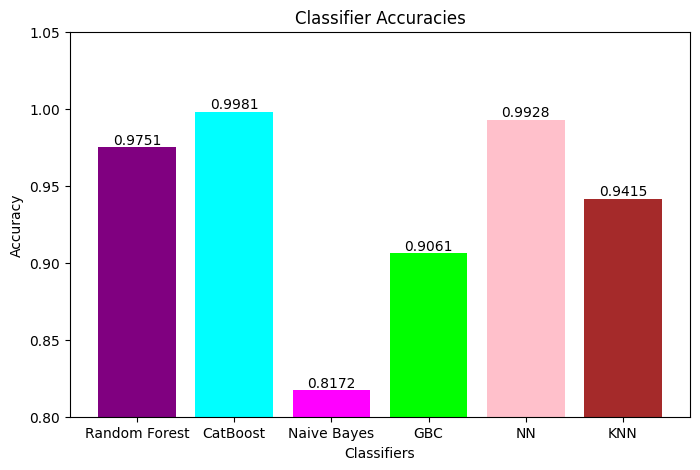

In [ ]:
import matplotlib.pyplot as plt

# Define the algorithms and their corresponding accuracies
classifiers = ['Random Forest', 'CatBoost', 'Naive Bayes', 'GBC', 'NN', 'KNN']
accuracies = [0.975073, 0.998129, 0.817164, 0.906068, 0.9928, 0.9415]

# Create the bar chart
plt.figure(figsize=(8, 5))
colors = ['purple', 'cyan', 'magenta', 'lime', 'pink', 'brown']
bars = plt.bar(classifiers, accuracies, color=colors)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 4), ha='center', va='bottom')

# Set labels and title
plt.ylabel('Accuracy')
plt.xlabel('Classifiers')
plt.title('Classifier Accuracies')
plt.ylim(0.8, 1.05)

plt.show()


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

<Figure size 800x600 with 0 Axes>

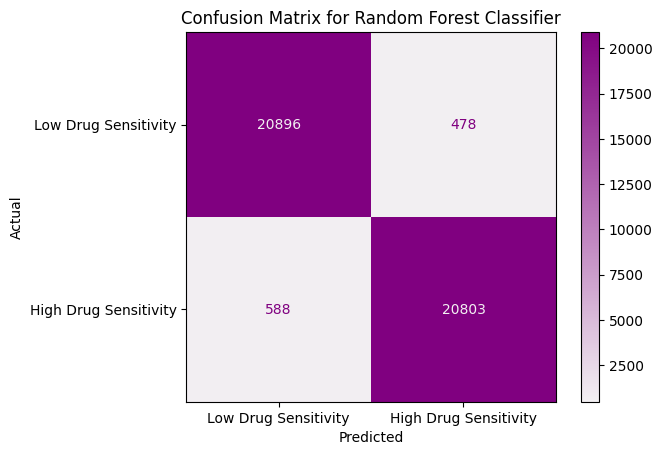

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute the confusion matrix
rf_confusion_matrix = confusion_matrix(y_test, rf_y_pred_class)

# Define a custom color map: light purple
custom_cmap = sns.light_palette("purple", reverse=False, as_cmap=True)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=rf_confusion_matrix,
                              display_labels=['Low Drug Sensitivity', 'High Drug Sensitivity'])

# Plot the confusion matrix using the custom colormap
plt.figure(figsize=(8, 6))
disp.plot(cmap=custom_cmap, values_format='d')
plt.title('Confusion Matrix for Random Forest Classifier')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()



<Figure size 800x600 with 0 Axes>

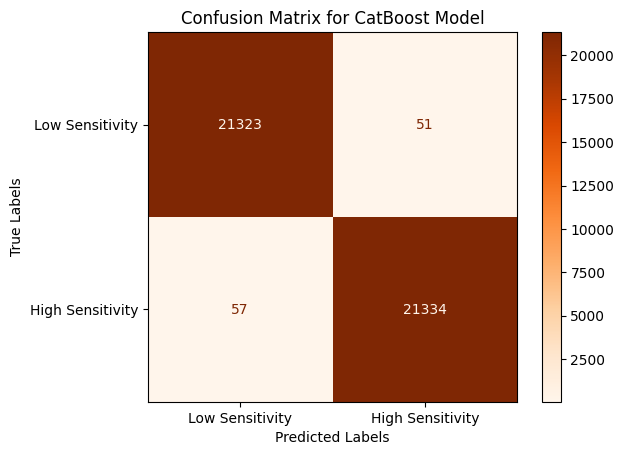

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Make predictions using the CatBoost model
catboost_predictions = catboost_model.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, catboost_predictions)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Low Sensitivity', 'High Sensitivity'])

# Plot the confusion matrix using the display object
plt.figure(figsize=(8, 6))
disp.plot(cmap='Oranges', values_format='d')
plt.title('Confusion Matrix for CatBoost Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


<Figure size 800x600 with 0 Axes>

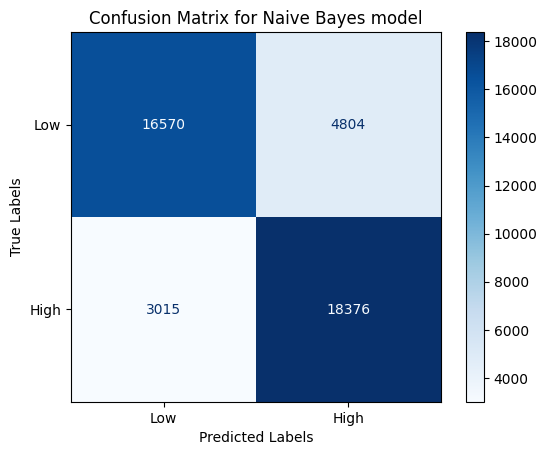

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Generate predictions from the Naive Bayes model
nb_y_pred_class = nb_model.predict(X_test)

# Create the confusion matrix
conf_matrix = confusion_matrix(y_test, nb_y_pred_class)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=['Low', 'High'])

# Plot the confusion matrix using the display object
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Naive Bayes model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()







<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

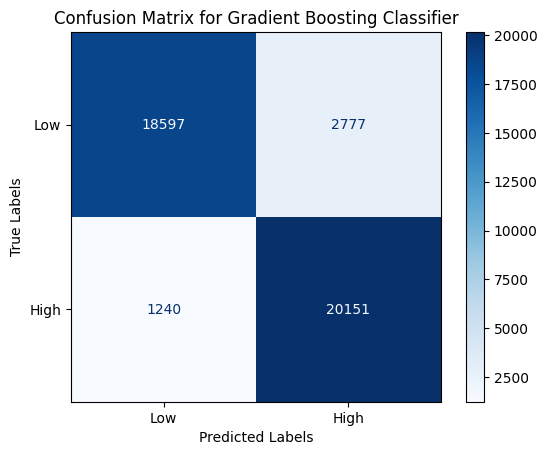

In [ ]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Generate confusion matrix
cm = confusion_matrix(y_test, gbm_y_pred_class)

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['Low', 'High'])


plt.figure(figsize=(8, 6))

# Plot the confusion matrix using the display object
plt.figure(figsize=(8, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Gradient Boosting Classifier')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



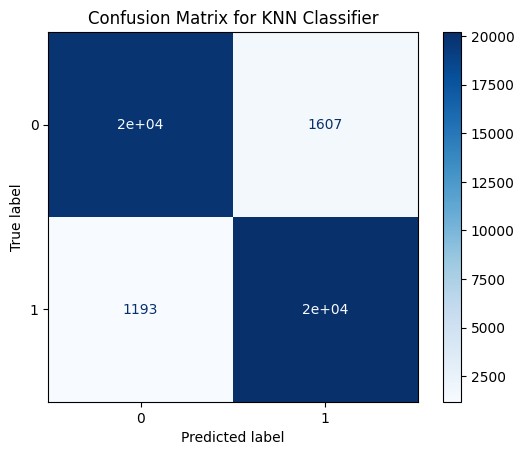

Confusion Matrix:
 [[19767  1607]
 [ 1193 20198]]


In [ ]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier

# Create and fit the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Make predictions with KNN Classifier
knn_y_pred_class = knn_model.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, knn_y_pred_class)

# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for KNN Classifier")
plt.show()

print("Confusion Matrix:\n", cm)

<Figure size 600x600 with 0 Axes>

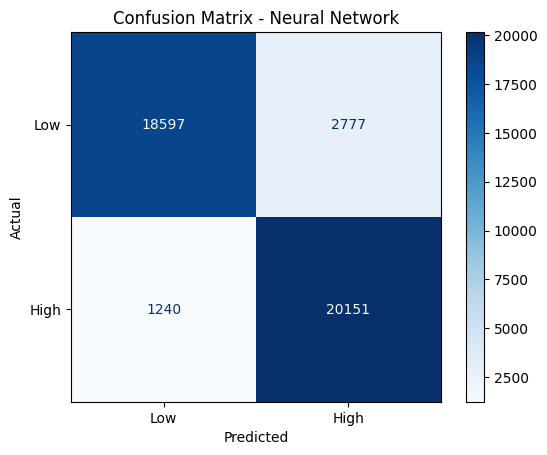

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Model evaluation: get predictions on the validation set
model.eval()
with torch.no_grad():
    test_outputs = model(X_val_tensor).squeeze()
    test_predictions = (test_outputs >= 0.5).float()  # Convert probabilities to binary

# Convert PyTorch tensors to NumPy arrays for use with scikit-learn
y_val_np = y_val_tensor.cpu().numpy()
test_predictions_np = test_predictions.cpu().numpy()

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_val_np, test_predictions_np)

# Plot confusion matrix using seaborn's heatmap for better visualization
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Neural Network')
plt.show()



In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report


report = classification_report(y_test, rf_y_pred_class, target_names=["Low Drug Sensitivity", "High Drug Sensitivity"], output_dict=True)

# Create a DataFrame to display precision, recall, f1-score for each class
report_df = pd.DataFrame(report).transpose()

metrics_table = report_df[['precision', 'recall', 'f1-score']]


print(metrics_table)


                       precision    recall  f1-score
Low Drug Sensitivity    0.972631  0.977636  0.975127
High Drug Sensitivity   0.977539  0.972512  0.975019
accuracy                0.975073  0.975073  0.975073
macro avg               0.975085  0.975074  0.975073
weighted avg            0.975086  0.975073  0.975073


In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_test, catboost_y_pred_class, target_names=["Low Drug Sensitivity", "High Drug Sensitivity"], output_dict=True)

# Convert the report to a DataFrame for better visualization
metrics_df = pd.DataFrame(report).transpose()

# Select relevant metrics and format the DataFrame
metrics_table = metrics_df[['precision', 'recall', 'f1-score']]
metrics_table.columns = ['Precision', 'Recall', 'F1 Score']

print(metrics_table)

                       Precision    Recall  F1 Score
Low Drug Sensitivity    0.998222  0.998035  0.998128
High Drug Sensitivity   0.998037  0.998224  0.998130
accuracy                0.998129  0.998129  0.998129
macro avg               0.998129  0.998129  0.998129
weighted avg            0.998129  0.998129  0.998129


In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report

# Make predictions with Naive Bayes Classifier
nb_y_pred_class = nb_model.predict(X_test)

# Generate classification report
report = classification_report(y_test, nb_y_pred_class, target_names=['Low Drug Sensitivity', 'High Drug Sensitivity'], output_dict=True)

# Convert report to a DataFrame for better visualization
metrics_df = pd.DataFrame(report).transpose()


metrics_df = metrics_df[['precision', 'recall', 'f1-score']]


print(metrics_df)

                       precision    recall  f1-score
Low Drug Sensitivity    0.846056  0.775241  0.809102
High Drug Sensitivity   0.792752  0.859053  0.824572
accuracy                0.817164  0.817164  0.817164
macro avg               0.819404  0.817147  0.816837
weighted avg            0.819393  0.817164  0.816840


In [ ]:
from sklearn.metrics import classification_report
import pandas as pd


# Generate classification report
report = classification_report(y_test, gbm_y_pred_class, target_names=['Low Drug Sensitivity', 'High Drug Sensitivity'], output_dict=True)

# Convert the report to a DataFrame
report_df = pd.DataFrame(report).transpose()

# Select only relevant columns
precision_recall_f1 = report_df[['precision', 'recall', 'f1-score']]
print(precision_recall_f1)

                       precision    recall  f1-score
Low Drug Sensitivity    0.937491  0.870076  0.902526
High Drug Sensitivity   0.878882  0.942032  0.909362
accuracy                0.906068  0.906068  0.906068
macro avg               0.908186  0.906054  0.905944
weighted avg            0.908174  0.906068  0.905945


In [ ]:
# Import necessary libraries
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

# Create and fit the KNN model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_y_pred_class = knn_model.predict(X_test)

# classification report
report = classification_report(y_test, knn_y_pred_class, target_names=["Low Drug Sensitivity", "High Drug Sensitivity"], output_dict=True)

metrics_df = pd.DataFrame(report).transpose()
metrics_df = metrics_df.loc[["Low Drug Sensitivity", "High Drug Sensitivity"], ["precision", "recall", "f1-score"]]


print(metrics_df)

                       precision    recall  f1-score
Low Drug Sensitivity    0.943082  0.924815  0.933859
High Drug Sensitivity   0.926301  0.944229  0.935179


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

# Generate classification report from predictions
classification_report_nn = classification_report(y_val_np, test_predictions_np, target_names=['Low Sensitivity', 'High Sensitivity'])

# Print classification report (includes precision, recall, F1-score, and support)
print("Classification Report of Neural Network:")
print(classification_report_nn)

# If you want to extract individual scores and store them in a DataFrame:
precision_nn = precision_score(y_val_np, test_predictions_np)
recall_nn = recall_score(y_val_np, test_predictions_np)
f1_nn = f1_score(y_val_np, test_predictions_np)

# Create a DataFrame to display metrics for the neural network model
import pandas as pd

metrics_nn_df = pd.DataFrame({
    'Metric': ['Precision', 'Recall', 'F1 Score'],
    'Neural Network': [precision_nn, recall_nn, f1_nn]
})

print(metrics_nn_df)

Classification Report of Neural Network:
                  precision    recall  f1-score   support

 Low Sensitivity       0.99      0.99      0.99     21374
High Sensitivity       0.99      0.99      0.99     21391

        accuracy                           0.99     42765
       macro avg       0.99      0.99      0.99     42765
    weighted avg       0.99      0.99      0.99     42765

      Metric  Neural Network
0  Precision        0.990753
1     Recall        0.991725
2   F1 Score        0.991239
